# Building chatbot with multiple tools using langgraph

## aim

create a chatbot with tool capabilities from arxiv, wikipedia search and some functions

In [ ]:
pip install arxiv

In [6]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper



In [7]:
api_wrapper_arxiv=ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [8]:
arxiv.invoke("Difference between in  Machine learning and Deep Learning")

ConnectionError: HTTPSConnectionPool(host='export.arxiv.org', port=443): Max retries exceeded with url: /api/query?search_query=Difference+between+in++Machine+learning+and+Deep+Learning&id_list=&sortBy=relevance&sortOrder=descending&start=0&max_results=100 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000024CFC3F4EC0>: Failed to resolve 'export.arxiv.org' ([Errno 11001] getaddrinfo failed)"))

In [24]:
from dotenv import load_dotenv
load_dotenv()

import os

os.environ['TAVILY_API_KEY'] =os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["LANGCHAIN_API_KEY"]=os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_PROJECT"]="ReAct-agent"

In [10]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()

C:\Users\Himanshu\AppData\Local\Temp\ipykernel_10936\735679136.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


In [6]:
tavily.invoke("Provide me the current ai news")

[{'title': "Three Biggest AI Stories in Nov. 2025: 'AI is no longer siloed'",
  'url': 'https://etcjournal.com/2025/11/13/three-biggest-ai-stories-in-nov-2025-ai-is-no-longer-siloed/',
  'content': 'The Keyword’s official recap, “The latest AI news we announced in October,” published on November 4, 2025, offers one of the clearest snapshots of a platform-scale shift: Google aligning workplace AI under Gemini Enterprise, unveiling research tools like Cell2Sentence-Scale for oncology, and highlighting a quantum algorithm that outpaces supercomputers for specific tasks. This article, authored by the Keyword Team, is compelling not just for the breadth of updates but for how they converge: [...] |  | 週刊AIニュース：日米韓インフラ投資、C… on Five Emerging AI Trends in Lat… | [...] Among October’s most consequential developments was the reported “gigawatt era” hardware surge—epitomized by the OpenAI & NVIDIA 10 GW partnership referenced in Netanel Siboni’s “What’s New in AI? The Latest AI News October 2025,

In [11]:
### Combine all the tools in the list

tools = [arxiv,tavily]

In [12]:
## initialize my llm model

from langchain_groq import ChatGroq

llm= ChatGroq(model="qwen/qwen3-32b")

llm_with_tool=llm.bind_tools(tools)

In [13]:
from pprint import pprint

from langchain_core.messages import AIMessage, HumanMessage
llm_with_tool.invoke([HumanMessage(content=f"What is recent AI News")]).tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'recent AI news'},
  'id': 'fjcvx674n',
  'type': 'tool_call'}]

In [14]:
## State Schema

from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages
class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]
    

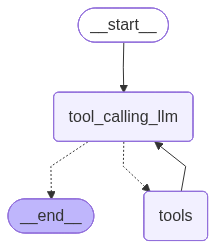

In [25]:
## Entire chatbot with langgraph 

from IPython.display import Image,display
from langgraph.graph import StateGraph , START , END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

def tool_calling_llm(state:State):
    return{"messages":[llm_with_tool.invoke(state["messages"])]}

#Build graph 
builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
     # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END

     tools_condition
)
builder.add_edge("tools","tool_calling_llm")

graph = builder.compile()

#view

# Use the builder object to visualize the graph before compilation
display(Image(graph.get_graph().draw_mermaid_png()))

In [23]:
messages=graph.invoke({"messages":HumanMessage(content="Provide me top 10 ai news")})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Provide me top 10 ai news
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (b9zb7kykg)
 Call ID: b9zb7kykg
  Args:
    query: top 10 AI news
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "AI Magazine: Home of AI and Artificial Intelligence News", "url": "https://aimagazine.com/", "content": "Vineet Kapoor on how the managed services provider helps enterprises navigate hybrid cloud transformation and build foundations for AI adoption…\n\nRead More\n\nTop 10\n\nView all\n\n### Top 10: Edge AI Solutions\n\nThe edge AI market is surging\n\nin specialisation as global\n\nspending on edge computing\n\nsolutions is set to spike, de……\n\n### Top 10: AI Leaders\n\nAI leaders are shaping the\n\nnow and future of AI through\n\ninfrastructure, innovation,\n\nresearch